<p style="font-family: 'Courier New', Courier, monospace; font-size: 30px; font-weight: bold; color: blue;  text-align: left;">
 PLM Modelling and Comaprison
</p>

In [2]:
# === Libraries ===
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import matplotlib.pyplot as plt  # For plotting and visualizations
import seaborn as sns  # For enhanced data visualizations
import plotly.express as px  # For interactive data visualizations
from sklearn.model_selection import KFold, train_test_split  # For splitting data and cross-validation
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.metrics import mean_squared_error, r2_score  # For model evaluation metrics
from scipy.optimize import curve_fit  # For curve fitting functions

In [3]:
# === Loading and Cleaning Data ===
# Load the original data into 'dat'
#dat = pd.read_csv('../all_data_files/visually_cleaned_df.csv', index_col=0)

# Load the cleaned data by IF into 'df'
df = pd.read_csv('../all_data_files/cleaned_dataset_per_device.csv', index_col=0)

In [4]:
# === Defining Models, Fitting, and Extracting Parameters ===
# -------------------------------
# Section 1: LDPLM-MW Model
# -------------------------------

# Extract necessary columns for LDPLM-MW
d_mw = df['distance'].values          # Distance in meters
c_walls_mw = df['c_walls'].values    # Number of brick walls
w_walls_mw = df['w_walls'].values    # Number of wood walls
PL_mw = df['exp_pl'].values          # Experimental path loss in dB

# Define the enhanced Log-Distance Path Loss Model with separate wall losses
def log_distance_path_loss_separate_walls(x, PL_d0, n, L_c, L_w):
    d, c_walls, w_walls = x
    d0 = 1  # Reference distance in meters
    return PL_d0 + 10 * n * np.log10(d / d0) + c_walls * L_c + w_walls * L_w

# Split the data into training and testing sets (80-20 split)
d_train_mw, d_test_mw, c_walls_train_mw, c_walls_test_mw, w_walls_train_mw, w_walls_test_mw, PL_train_mw, PL_test_mw = train_test_split(
    d_mw, c_walls_mw, w_walls_mw, PL_mw, test_size=0.2, random_state=50
)

# Define input for curve_fit
x_train_mw = (d_train_mw, c_walls_train_mw, w_walls_train_mw)

# Initial guesses for PL_d0, n, L_c, and L_w
initial_guesses_mw = [30, 2, 5, 3]  # Can be adjusted 

# Perform curve fitting
popt_mw, pcov_mw = curve_fit(
    log_distance_path_loss_separate_walls,
    x_train_mw,
    PL_train_mw,
    p0=initial_guesses_mw,
    maxfev=10000  #  To be increased if convergence issues arise
)

# Extract the fitted parameters for LDPLM-MW
PL_d0_mw, n_mw, L_c_mw, L_w_mw = popt_mw

# Predict path loss for the test set
x_test_mw = (d_test_mw, c_walls_test_mw, w_walls_test_mw)
PL_pred_mw = log_distance_path_loss_separate_walls(x_test_mw, PL_d0_mw, n_mw, L_c_mw, L_w_mw)

# Calculate the shadowing component for the training set
PL_train_pred_mw = log_distance_path_loss_separate_walls(x_train_mw, PL_d0_mw, n_mw, L_c_mw, L_w_mw)
shadowing_train_mw = PL_train_mw - PL_train_pred_mw
sigma_mw = np.std(shadowing_train_mw)

# Calculate RMSE and R-squared for LDPLM-MW on Test Set
rmse_mw = np.sqrt(mean_squared_error(PL_test_mw, PL_pred_mw))
r_squared_mw = r2_score(PL_test_mw, PL_pred_mw)

# Calculate RMSE and R-squared on Training Set 
# Calculate RMSE for LDPLM-MW on Training Set
rmse_train_mw = np.sqrt(mean_squared_error(PL_train_mw, PL_train_pred_mw))
# Calculate R-squared for LDPLM-MW on Training Set
r_squared_train_mw = r2_score(PL_train_mw, PL_train_pred_mw)

In [5]:
# === Defining Models, Fitting, and Extracting Parameters ===
# -------------------------------
# Section 2: LDPLM-MW-EP Model
# -------------------------------

# Extract necessary columns for LDPLM-MW-EP
d_ep = df['distance'].values          # Distance in meters
c_walls_ep = df['c_walls'].values    # Number of brick walls
w_walls_ep = df['w_walls'].values    # Number of wood walls
PL_ep = df['exp_pl'].values          # Experimental path loss in dB

# Environmental parameters
co2_ep = df['co2'].values
humidity_ep = df['humidity'].values
pm25_ep = df['pm25'].values
pressure_ep = df['pressure'].values
temperature_ep = df['temperature'].values

# New parameters
frequency_ep = df['frequency'].values  # Frequency in MHz
snr_ep = df['snr'].values              # Signal-to-Noise Ratio

# Define the enhanced Log-Distance Path Loss Model with frequency and SNR
def log_distance_path_loss_with_freq_snr(x, PL_d0, n, L_c, L_w, a_co2, a_hum, a_pm25, a_pres, a_temp, k_snr):
    d, c_walls, w_walls, co2, humidity, pm25, pressure, temperature, frequency, snr = x
    d0 = 1  # Reference distance in meters
    return (PL_d0 + 10 * n * np.log10(d / d0) + c_walls * L_c + w_walls * L_w + 
            a_co2 * co2 + a_hum * humidity + a_pm25 * pm25 + 
            a_pres * pressure + a_temp * temperature + 
            20 * np.log10(frequency) - snr * k_snr)

# Split the data into training and testing sets (80-20 split)
split = train_test_split(
    d_ep, c_walls_ep, w_walls_ep, PL_ep, co2_ep, humidity_ep, pm25_ep, pressure_ep, temperature_ep, frequency_ep, snr_ep, 
    test_size=0.2, random_state=50
)

(
    d_train_ep, d_test_ep, 
    c_walls_train_ep, c_walls_test_ep, 
    w_walls_train_ep, w_walls_test_ep, 
    PL_train_ep, PL_test_ep, 
    co2_train_ep, co2_test_ep, 
    humidity_train_ep, humidity_test_ep, 
    pm25_train_ep, pm25_test_ep, 
    pressure_train_ep, pressure_test_ep, 
    temperature_train_ep, temperature_test_ep, 
    frequency_train_ep, frequency_test_ep, 
    snr_train_ep, snr_test_ep
) = split

# Define input for curve_fit
x_train_ep = (
    d_train_ep, c_walls_train_ep, w_walls_train_ep, co2_train_ep, humidity_train_ep, pm25_train_ep, 
    pressure_train_ep, temperature_train_ep, frequency_train_ep, snr_train_ep
)

# Initial guesses for PL_d0, n, L_c, L_w, and environmental factors, and SNR coefficient
initial_guesses_ep = [30, 2, 5, 3, 0.01, 0.01, 0.01, 0.01, 0.01, 1]  # Can be adjusted 

# Perform curve fitting
popt_ep, pcov_ep = curve_fit(
    log_distance_path_loss_with_freq_snr,
    x_train_ep,
    PL_train_ep,
    p0=initial_guesses_ep,
    maxfev=10000  # To be increased if convergence issues arise
)

# Extract the fitted parameters for LDPLM-MW-EP
PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep = popt_ep

# Predict path loss for the test set
x_test_ep = (
    d_test_ep, c_walls_test_ep, w_walls_test_ep, co2_test_ep, humidity_test_ep, pm25_test_ep, 
    pressure_test_ep, temperature_test_ep, frequency_test_ep, snr_test_ep
)
PL_pred_ep = log_distance_path_loss_with_freq_snr(
    x_test_ep, PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep
)

# Calculate the shadowing component for the training set
PL_train_pred_ep = log_distance_path_loss_with_freq_snr(
    x_train_ep, PL_d0_ep, n_ep, L_c_ep, L_w_ep, a_co2_ep, a_hum_ep, a_pm25_ep, a_pres_ep, a_temp_ep, k_snr_ep
)
shadowing_train_ep = PL_train_ep - PL_train_pred_ep
sigma_ep = np.std(shadowing_train_ep)

# Calculate RMSE and R-squared for LDPLM-MW-EP on Test Set
rmse_ep = np.sqrt(mean_squared_error(PL_test_ep, PL_pred_ep))
r_squared_ep = r2_score(PL_test_ep, PL_pred_ep)

# Calculate RMSE and R-squared on Training Set
# Calculate RMSE for LDPLM-MW-EP on Training Set
rmse_train_ep = np.sqrt(mean_squared_error(PL_train_ep, PL_train_pred_ep))
# Calculate R-squared for LDPLM-MW-EP on Training Set
r_squared_train_ep = r2_score(PL_train_ep, PL_train_pred_ep)

In [6]:
# -------------------------------
# Section 3: Compare Parameters and Metrics
# -------------------------------

# Parameters Comparison
params_mw = {
    'PL(d0) [dB]': PL_d0_mw,
    'Path loss exponent (n)': n_mw,
    'Brick Wall Loss (L_c) [dB]': L_c_mw,
    'Wood Wall Loss (L_w) [dB]': L_w_mw
}

params_ep = {
    'PL(d0) [dB]': PL_d0_ep,
    'Path loss exponent (n)': n_ep,
    'Brick Wall Loss (L_c) [dB]': L_c_ep,
    'Wood Wall Loss (L_w) [dB]': L_w_ep,
    'CO2 coefficient (a_co2) [dB/unit]': a_co2_ep,
    'Humidity coefficient (a_hum) [dB/unit]': a_hum_ep,
    'PM2.5 coefficient (a_pm25) [dB/unit]': a_pm25_ep,
    'Pressure coefficient (a_pres) [dB/unit]': a_pres_ep,
    'Temperature coefficient (a_temp) [dB/unit]': a_temp_ep,
    'SNR scaling factor (k_snr)': k_snr_ep
}

# Define the list of shared and unique parameters
shared_params = ['PL(d0) [dB]', 'Path loss exponent (n)', 'Brick Wall Loss (L_c) [dB]', 'Wood Wall Loss (L_w) [dB]']
unique_params_ep = [
    'CO2 coefficient (a_co2) [dB/unit]', 
    'Humidity coefficient (a_hum) [dB/unit]', 
    'PM2.5 coefficient (a_pm25) [dB/unit]', 
    'Pressure coefficient (a_pres) [dB/unit]', 
    'Temperature coefficient (a_temp) [dB/unit]', 
    'SNR scaling factor (k_snr)'
]

# Create the Parameter list: shared parameters + unique EP parameters
parameter_list = shared_params + unique_params_ep  # Total 10 parameters

# Create the LDPLM-MW column: shared parameters' values + '-' for unique EP parameters
ldplm_mw_values = [params_mw[param] for param in shared_params] + ['-' for _ in unique_params_ep]

# Create the LDPLM-MW-EP column: shared parameters' values + unique EP parameters' values
ldplm_ep_values = [params_ep[param] for param in shared_params] + [params_ep[param] for param in unique_params_ep]

# Construct the DataFrame
params_df = pd.DataFrame({
    'Parameter': parameter_list,
    'LDPLM-MW': ldplm_mw_values,
    'LDPLM-MW-EP': ldplm_ep_values
})

print("\n=== Table of Parameters to be Compared ===\n")
display(params_df)

# Metrics Comparison Including Training and Test Sets 
# Metrics Comparison
metrics = [
    'RMSE (Train) [dB]', 
    'RMSE (Test) [dB]', 
    'R-squared (Train)', 
    'R-squared (Test)', 
    'Shadowing σ (dB)'
]
metrics_values = {
    'LDPLM-MW': [rmse_train_mw, rmse_mw, r_squared_train_mw, r_squared_mw, sigma_mw],
    'LDPLM-MW-EP': [rmse_train_ep, rmse_ep, r_squared_train_ep, r_squared_ep, sigma_ep]
}

metrics_df = pd.DataFrame(metrics_values, index=metrics)

print("\n=== Performance Metrics Comparison ===\n")
display(metrics_df)


=== Table of Parameters to be Compared ===



,Parameter,LDPLM-MW,LDPLM-MW-EP
0,PL(d0) [dB],23.764735,19.311559
1,Path loss exponent (n),4.226293,3.691479
2,Brick Wall Loss (L_c) [dB],8.399276,7.553318
3,Wood Wall Loss (L_w) [dB],2.588306,3.004294
4,CO2 coefficient (a_co2) [dB/unit],-,-0.001518
5,Humidity coefficient (a_hum) [dB/unit],-,-0.141159
6,PM2.5 coefficient (a_pm25) [dB/unit],-,-0.038518
7,Pressure coefficient (a_pres) [dB/unit],-,-0.053317
8,Temperature coefficient (a_temp) [dB/unit],-,-0.187912
9,SNR scaling factor (k_snr),-,1.963819



=== Performance Metrics Comparison ===



,LDPLM-MW,LDPLM-MW-EP
RMSE (Train) [dB],10.584861,8.377450
RMSE (Test) [dB],10.459968,8.300619
R-squared (Train),0.724959,0.827714
R-squared (Test),0.731728,0.831059
Shadowing σ (dB),10.584861,8.377450


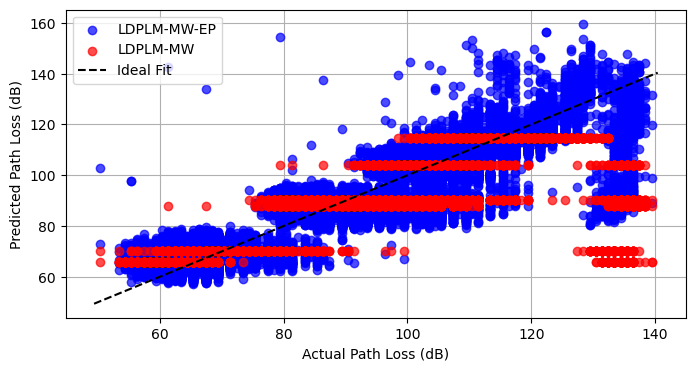

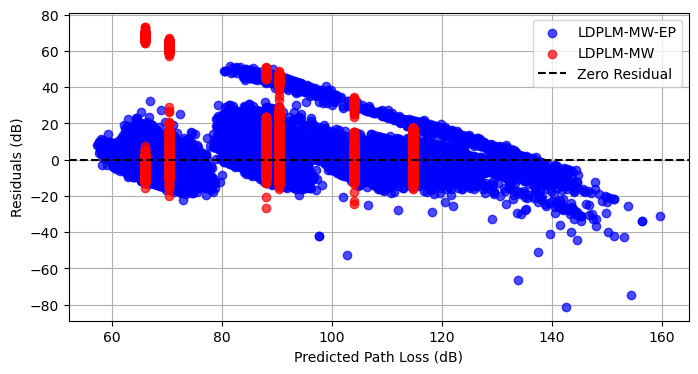

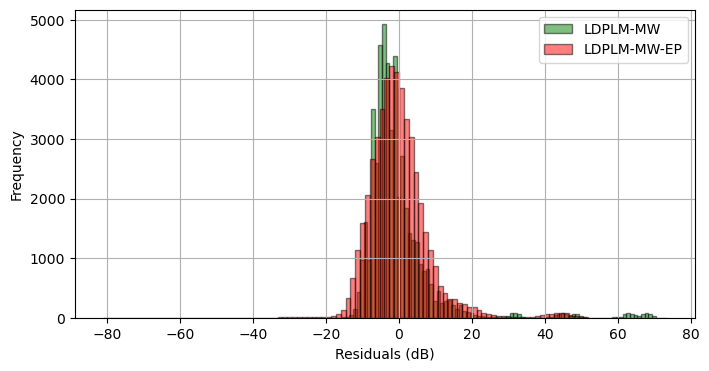


Residual Distribution Values:

LDPLM-MW: Mean:-0.1106 dB, Skewness: 3.9048 dB
LDPLM-MW-EP: Mean:-0.0817 dB, Skewness: 1.7262 dB


In [7]:
# -------------------------------
# Section 4: Plotting
# -------------------------------

# Step 15: Plot Actual vs Predicted Path Loss
plt.figure(figsize=(8, 4))
# Plot LDPLM-MW-EP first in green
plt.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW last in blue to appear in foreground
plt.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Ideal Fit Line in black, highest zorder to appear on top
plt.plot(
    [min(PL_mw.min(), PL_ep.min()), max(PL_mw.max(), PL_ep.max())], 
    [min(PL_mw.min(), PL_ep.min()), max(PL_mw.max(), PL_ep.max())], 
    'k--', label='Ideal Fit', zorder=4
)
plt.xlabel('Actual Path Loss (dB)')
plt.ylabel('Predicted Path Loss (dB)')
#plt.title('Actual vs Predicted Path Loss Comparison')
plt.legend()
plt.grid(True)
plt.savefig('../all_data_files/Actual_vs_Predicted.png', dpi=1000)
plt.show()

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss
residuals_mw = PL_test_mw - PL_pred_mw
residuals_ep = PL_test_ep - PL_pred_ep

plt.figure(figsize=(8, 4))
# Plot LDPLM-MW-EP residuals first in green
plt.scatter(PL_pred_ep, residuals_ep, alpha=0.7, label='LDPLM-MW-EP',  color='blue', zorder=2)
# Plot LDPLM-MW residuals last in blue to appear in foreground
plt.scatter(PL_pred_mw, residuals_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Horizontal line at zero in black, highest zorder to appear on top
plt.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
plt.xlabel('Predicted Path Loss (dB)')
plt.ylabel('Residuals (dB)')
#plt.title('Residuals vs Predicted Path Loss Comparison')
plt.legend()
plt.grid(True)
plt.savefig('../all_data_files/Residuals_vs_Predicted.png', dpi=1000)
plt.show()

# Step 17: Residual Analysis - Histogram of Residuals
plt.figure(figsize=(8, 4))
plt.hist(residuals_mw, bins=100, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k')
plt.hist(residuals_ep, bins=100, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k')
plt.xlabel('Residuals (dB)')
plt.ylabel('Frequency')
#plt.title('Histogram of Residuals Comparison')
plt.legend()
plt.grid(True)
plt.savefig('../all_data_files/Histogram_of_Residuals.png', dpi=1000)
plt.show()

# Convert numpy arrays to pandas Series
residuals_mw = pd.Series(residuals_mw)
residuals_ep = pd.Series(residuals_ep)

# Residual Distribution Values
resid_mean_mw = round(residuals_mw.mean(), 4)
resid_skew_mw = round(residuals_mw.skew(), 4)

resid_mean_ep = round(residuals_ep.mean(), 4)
resid_skew_ep = round(residuals_ep.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW: Mean:{resid_mean_mw} dB, Skewness: {resid_skew_mw} dB')
print(f'LDPLM-MW-EP: Mean:{resid_mean_ep} dB, Skewness: {resid_skew_ep} dB')

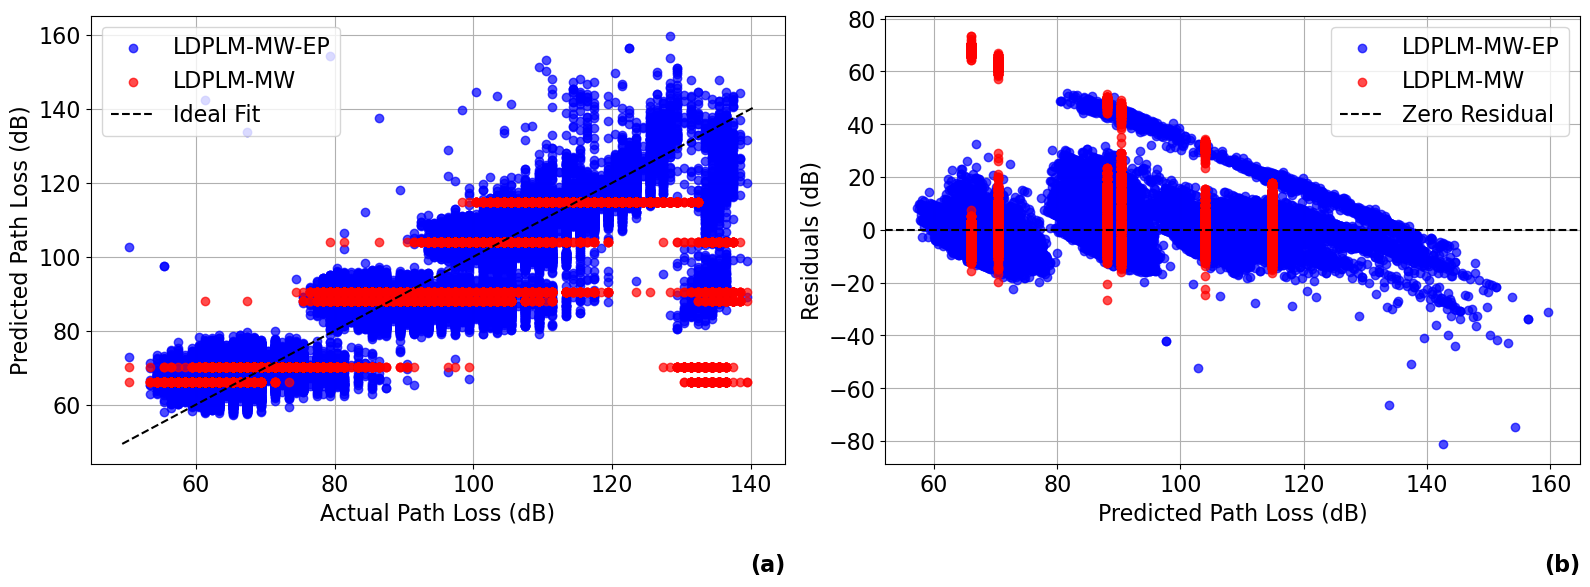

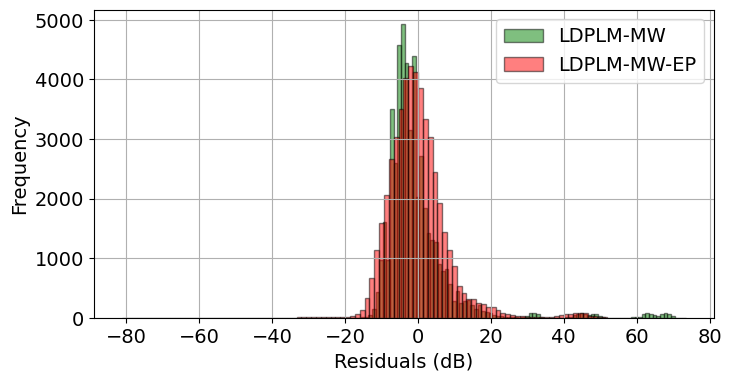


Residual Distribution Values:

LDPLM-MW: Mean:-0.1106 dB, Skewness: 3.9048 dB
LDPLM-MW-EP: Mean:-0.0817 dB, Skewness: 1.7262 dB


In [8]:
# -------------------------------
# Section 4: Plotting
# -------------------------------

# Step 15 & 16: Plot Actual vs Predicted Path Loss and Residual Analysis as Subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Step 15: Plot Actual vs Predicted Path Loss on ax1
# Plot LDPLM-MW-EP first in blue
ax1.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW last in red to appear in foreground
ax1.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Ideal Fit Line in black, highest zorder to appear on top
ax1.plot(
    [min(PL_mw.min(), PL_ep.min()), max(PL_mw.max(), PL_ep.max())], 
    [min(PL_mw.min(), PL_ep.min()), max(PL_mw.max(), PL_ep.max())], 
    'k--', label='Ideal Fit', zorder=4
)
ax1.set_xlabel('Actual Path Loss (dB)', fontsize=16)  
ax1.set_ylabel('Predicted Path Loss (dB)', fontsize=16)  
# ax1.set_title('Actual vs Predicted Path Loss Comparison')
ax1.legend(fontsize=16) 
ax1.grid(True)
ax1.tick_params(axis='both', which='major', labelsize=16)
# Add itemize label to the subplot
ax1.text(1, -0.2, '(a)', transform=ax1.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss on ax2
residuals_mw = PL_test_mw - PL_pred_mw
residuals_ep = PL_test_ep - PL_pred_ep

# Plot LDPLM-MW-EP residuals first in blue
ax2.scatter(PL_pred_ep, residuals_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW residuals last in red to appear in foreground
ax2.scatter(PL_pred_mw, residuals_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Horizontal line at zero in black, highest zorder to appear on top
ax2.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax2.set_xlabel('Predicted Path Loss (dB)', fontsize=16)  
ax2.set_ylabel('Residuals (dB)', fontsize=16)  
# ax2.set_title('Residuals vs Predicted Path Loss Comparison')
ax2.legend(fontsize=16)  
ax2.grid(True)
ax2.tick_params(axis='both', which='major', labelsize=16)
# Add itemize label to the subplot
ax2.text(1, -0.2, '(b)', transform=ax2.transAxes, fontsize=16, fontweight='bold', va='top', ha='right')  

# Adjust layout to prevent overlapping
plt.tight_layout()
# Save the combined figure
plt.savefig('../all_data_files/Actual_vs_Predicted_and_Residuals.png', dpi=1000)
plt.show()

# Step 17: Residual Analysis - Histogram of Residuals
plt.figure(figsize=(8, 4))
# Plot histogram for LDPLM-MW
plt.hist(residuals_mw, bins=100, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k')
# Plot histogram for LDPLM-MW-EP
plt.hist(residuals_ep, bins=100, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k')
plt.xlabel('Residuals (dB)', fontsize=14)  
plt.ylabel('Frequency', fontsize=14)  
# plt.title('Histogram of Residuals Comparison')
plt.legend(fontsize=14)  
plt.grid(True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('../all_data_files/Histogram_of_Residuals.png', dpi=1000)
plt.show()

# Convert numpy arrays to pandas Series
residuals_mw = pd.Series(residuals_mw)
residuals_ep = pd.Series(residuals_ep)

# Residual Distribution Values
resid_mean_mw = round(residuals_mw.mean(), 4)
resid_skew_mw = round(residuals_mw.skew(), 4)

resid_mean_ep = round(residuals_ep.mean(), 4)
resid_skew_ep = round(residuals_ep.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW: Mean:{resid_mean_mw} dB, Skewness: {resid_skew_mw} dB')
print(f'LDPLM-MW-EP: Mean:{resid_mean_ep} dB, Skewness: {resid_skew_ep} dB')


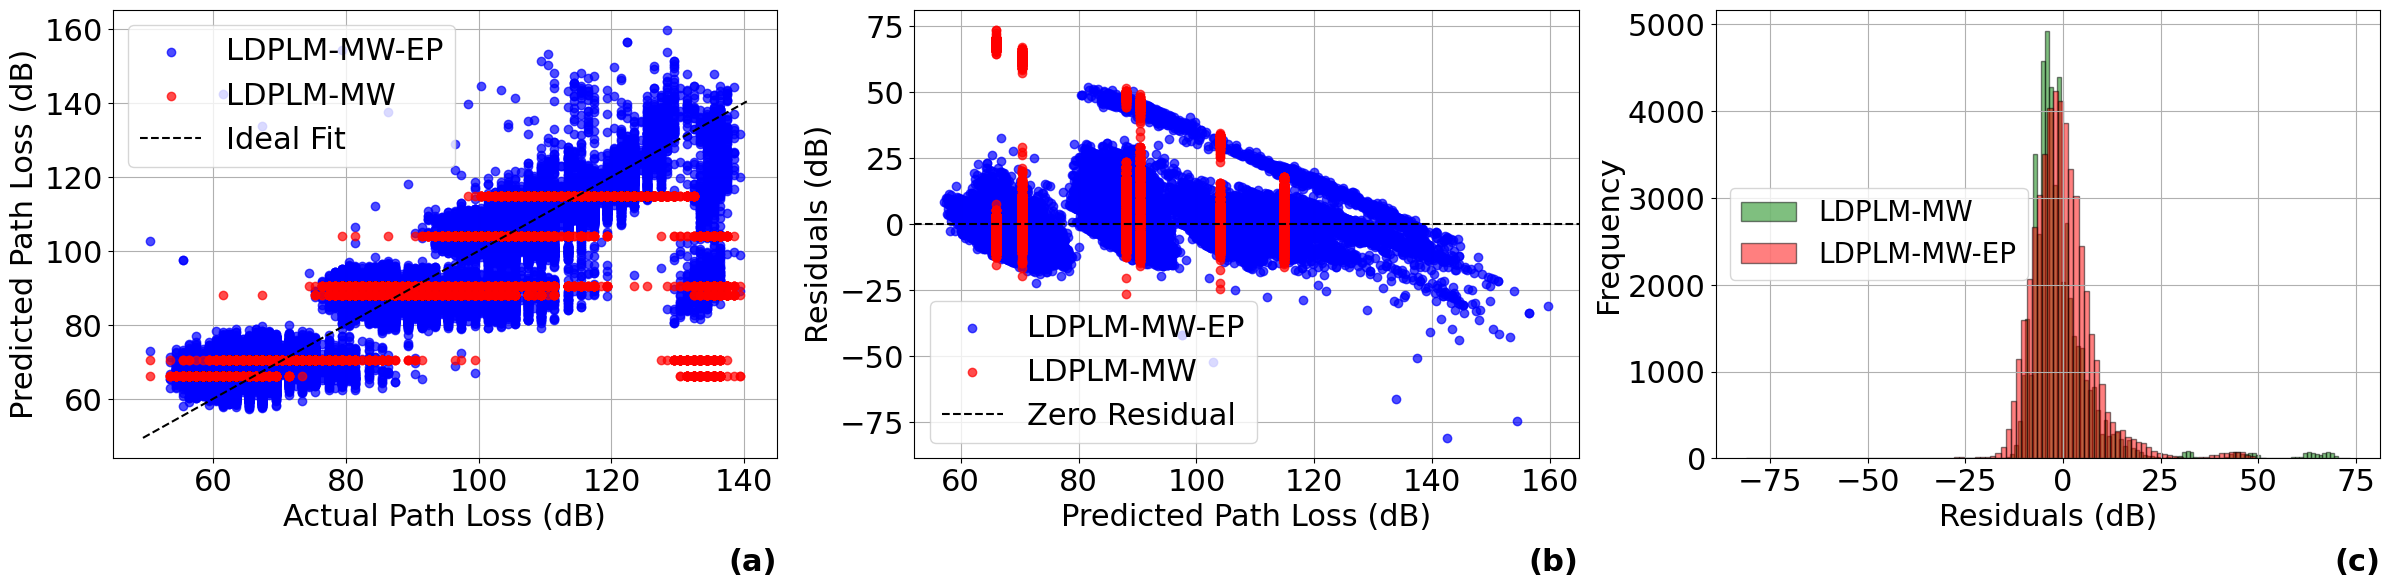


Residual Distribution Values:

LDPLM-MW: Mean:-0.1106 dB, Skewness: 3.9048 dB
LDPLM-MW-EP: Mean:-0.0817 dB, Skewness: 1.7262 dB


In [9]:
# -------------------------------
# Section 4: Plotting
# -------------------------------

# Step 15, 16 & 17: Plot Actual vs Predicted Path Loss, Residual Analysis, and Histogram as Subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

# Step 15: Plot Actual vs Predicted Path Loss on ax1
# Plot LDPLM-MW-EP first in blue
ax1.scatter(PL_test_ep, PL_pred_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW last in red to appear in foreground
ax1.scatter(PL_test_mw, PL_pred_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Ideal Fit Line in black, highest zorder to appear on top
ax1.plot(
    [min(PL_mw.min(), PL_ep.min()), max(PL_mw.max(), PL_ep.max())],
    [min(PL_mw.min(), PL_ep.min()), max(PL_mw.max(), PL_ep.max())],
    'k--', label='Ideal Fit', zorder=4
)
ax1.set_xlabel('Actual Path Loss (dB)', fontsize=22)
ax1.set_ylabel('Predicted Path Loss (dB)', fontsize=22)
# ax1.set_title('Actual vs Predicted Path Loss Comparison')
ax1.legend(fontsize=22)
ax1.grid(True)
# Increase tick label font size to 22
ax1.tick_params(axis='both', which='major', labelsize=22)
# Add itemize label to the subplot
ax1.text(1, -0.2, '(a)', transform=ax1.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 16: Residual Analysis - Residuals vs Predicted Path Loss on ax2
residuals_mw = PL_test_mw - PL_pred_mw
residuals_ep = PL_test_ep - PL_pred_ep

# Plot LDPLM-MW-EP residuals first in blue
ax2.scatter(PL_pred_ep, residuals_ep, alpha=0.7, label='LDPLM-MW-EP', color='blue', zorder=2)
# Plot LDPLM-MW residuals last in red to appear in foreground
ax2.scatter(PL_pred_mw, residuals_mw, alpha=0.7, label='LDPLM-MW', color='red', zorder=3)
# Horizontal line at zero in black, highest zorder to appear on top
ax2.axhline(0, color='k', linestyle='--', label='Zero Residual', zorder=4)
ax2.set_xlabel('Predicted Path Loss (dB)', fontsize=22)
ax2.set_ylabel('Residuals (dB)', fontsize=22)
# ax2.set_title('Residuals vs Predicted Path Loss Comparison')
ax2.legend(fontsize=22)
ax2.grid(True)
# Increase tick label font size to 22
ax2.tick_params(axis='both', which='major', labelsize=22)
# Add itemize label to the subplot
ax2.text(1, -0.2, '(b)', transform=ax2.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Step 17: Residual Analysis - Histogram of Residuals on ax3
# Plot histogram for LDPLM-MW
ax3.hist(residuals_mw, bins=100, alpha=0.5, label='LDPLM-MW', color='green', edgecolor='k')
# Plot histogram for LDPLM-MW-EP
ax3.hist(residuals_ep, bins=100, alpha=0.5, label='LDPLM-MW-EP', color='red', edgecolor='k')
ax3.set_xlabel('Residuals (dB)', fontsize=22)
ax3.set_ylabel('Frequency', fontsize=22)
# ax3.set_title('Histogram of Residuals Comparison')
ax3.legend(fontsize=20, loc='center left')
ax3.grid(True)
# Increase tick label font size to 22
ax3.tick_params(axis='both', which='major', labelsize=22)
# Add itemize label to the subplot
ax3.text(1, -0.2, '(c)', transform=ax3.transAxes, fontsize=22, fontweight='bold', va='top', ha='right')

# Adjust layout to prevent overlapping
plt.tight_layout()
# Save the combined figure
plt.savefig('../all_data_files/All_Plots_as_Subplots.png', dpi=1000)
plt.show()

# Convert numpy arrays to pandas Series
residuals_mw = pd.Series(residuals_mw)
residuals_ep = pd.Series(residuals_ep)

# Residual Distribution Values
resid_mean_mw = round(residuals_mw.mean(), 4)
resid_skew_mw = round(residuals_mw.skew(), 4)

resid_mean_ep = round(residuals_ep.mean(), 4)
resid_skew_ep = round(residuals_ep.skew(), 4)

print(f'\nResidual Distribution Values:')
print(f'\nLDPLM-MW: Mean:{resid_mean_mw} dB, Skewness: {resid_skew_mw} dB')
print(f'LDPLM-MW-EP: Mean:{resid_mean_ep} dB, Skewness: {resid_skew_ep} dB')


In [10]:
# -------------------------------
# Section 5: Cross-Validation
# -------------------------------

print("\n=== Cross-Validation (5-Fold) ===\n")

kf = KFold(n_splits=5, shuffle=True, random_state=50)

# Initialize lists to store metrics
rmse_list_mw_train = []
r_squared_list_mw_train = []
rmse_list_mw_test = []
r_squared_list_mw_test = []

rmse_list_ep_train = []
r_squared_list_ep_train = []
rmse_list_ep_test = []
r_squared_list_ep_test = []

for fold, (train_index, test_index) in enumerate(kf.split(df), 1):
    # === Cross-Validation for LDPLM-MW ===
    # Split data
    d_train_cv_mw, d_test_cv_mw = d_mw[train_index], d_mw[test_index]
    c_walls_train_cv_mw, c_walls_test_cv_mw = c_walls_mw[train_index], c_walls_mw[test_index]
    w_walls_train_cv_mw, w_walls_test_cv_mw = w_walls_mw[train_index], w_walls_mw[test_index]
    PL_train_cv_mw, PL_test_cv_mw = PL_mw[train_index], PL_mw[test_index]
    
    x_train_cv_mw = (d_train_cv_mw, c_walls_train_cv_mw, w_walls_train_cv_mw)
    
    try:
        popt_cv_mw, _ = curve_fit(
            log_distance_path_loss_separate_walls,
            x_train_cv_mw,
            PL_train_cv_mw,
            p0=initial_guesses_mw,
            maxfev=10000
        )
        
        PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw = popt_cv_mw
        
        x_test_cv_mw = (d_test_cv_mw, c_walls_test_cv_mw, w_walls_test_cv_mw)
        PL_pred_cv_mw = log_distance_path_loss_separate_walls(x_test_cv_mw, PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw)
        
        #  Calculate RMSE and R-squared on Test Set for LDPLM-MW
        rmse_cv_mw_test = np.sqrt(mean_squared_error(PL_test_cv_mw, PL_pred_cv_mw))
        r2_cv_mw_test = r2_score(PL_test_cv_mw, PL_pred_cv_mw)
        
        #  Calculate RMSE and R-squared on Training Set for LDPLM-MW 
        PL_train_pred_cv_mw = log_distance_path_loss_separate_walls(x_train_cv_mw, PL_d0_cv_mw, n_cv_mw, L_c_cv_mw, L_w_cv_mw)
        rmse_cv_mw_train = np.sqrt(mean_squared_error(PL_train_cv_mw, PL_train_pred_cv_mw))
        r2_cv_mw_train = r2_score(PL_train_cv_mw, PL_train_pred_cv_mw)
        
        rmse_list_mw_test.append(rmse_cv_mw_test)
        r_squared_list_mw_test.append(r2_cv_mw_test)
        
        rmse_list_mw_train.append(rmse_cv_mw_train)
        r_squared_list_mw_train.append(r2_cv_mw_train)
        
    except RuntimeError:
        print(f"Curve fitting failed for LDPLM-MW Fold {fold}.")
        rmse_list_mw_test.append(np.nan)
        r_squared_list_mw_test.append(np.nan)
        rmse_list_mw_train.append(np.nan)
        r_squared_list_mw_train.append(np.nan)
    
    # === Cross-Validation for LDPLM-MW-EP ===
    # Split data
    d_train_cv_ep = d_ep[train_index]
    d_test_cv_ep = d_ep[test_index]
    
    c_walls_train_cv_ep = c_walls_ep[train_index]
    c_walls_test_cv_ep = c_walls_ep[test_index]
    
    w_walls_train_cv_ep = w_walls_ep[train_index]
    w_walls_test_cv_ep = w_walls_ep[test_index]
    
    PL_train_cv_ep = PL_ep[train_index]
    PL_test_cv_ep = PL_ep[test_index]
    
    co2_train_cv_ep = co2_ep[train_index]
    co2_test_cv_ep = co2_ep[test_index]
    
    humidity_train_cv_ep = humidity_ep[train_index]
    humidity_test_cv_ep = humidity_ep[test_index]
    
    pm25_train_cv_ep = pm25_ep[train_index]
    pm25_test_cv_ep = pm25_ep[test_index]
    
    pressure_train_cv_ep = pressure_ep[train_index]
    pressure_test_cv_ep = pressure_ep[test_index]
    
    temperature_train_cv_ep = temperature_ep[train_index]
    temperature_test_cv_ep = temperature_ep[test_index]
    
    frequency_train_cv_ep = frequency_ep[train_index]
    frequency_test_cv_ep = frequency_ep[test_index]
    
    snr_train_cv_ep = snr_ep[train_index]
    snr_test_cv_ep = snr_ep[test_index]
    
    x_train_cv_ep = (
        d_train_cv_ep, c_walls_train_cv_ep, w_walls_train_cv_ep,
        co2_train_cv_ep, humidity_train_cv_ep, pm25_train_cv_ep,
        pressure_train_cv_ep, temperature_train_cv_ep,
        frequency_train_cv_ep, snr_train_cv_ep
    )
    
    try:
        popt_cv_ep, _ = curve_fit(
            log_distance_path_loss_with_freq_snr,
            x_train_cv_ep,
            PL_train_cv_ep,
            p0=initial_guesses_ep,
            maxfev=10000
        )
        
        PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep, a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep = popt_cv_ep
        
        x_test_cv_ep = (
            d_test_cv_ep, c_walls_test_cv_ep, w_walls_test_cv_ep,
            co2_test_cv_ep, humidity_test_cv_ep, pm25_test_cv_ep,
            pressure_test_cv_ep, temperature_test_cv_ep,
            frequency_test_cv_ep, snr_test_cv_ep
        )
        PL_pred_cv_ep = log_distance_path_loss_with_freq_snr(
            x_test_cv_ep, PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep,
            a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep
        )
        
        # Calculate RMSE and R-squared on Test Set for LDPLM-MW-EP
        rmse_cv_ep_test = np.sqrt(mean_squared_error(PL_test_cv_ep, PL_pred_cv_ep))
        r2_cv_ep_test = r2_score(PL_test_cv_ep, PL_pred_cv_ep)
        # === End of Added Section ===
        
        # Calculate RMSE and R-squared on Training Set for LDPLM-MW-EP 
        PL_train_pred_cv_ep = log_distance_path_loss_with_freq_snr(
            x_train_cv_ep, PL_d0_cv_ep, n_cv_ep, L_c_cv_ep, L_w_cv_ep,
            a_co2_cv_ep, a_hum_cv_ep, a_pm25_cv_ep, a_pres_cv_ep, a_temp_cv_ep, k_snr_cv_ep
        )
        rmse_cv_ep_train = np.sqrt(mean_squared_error(PL_train_cv_ep, PL_train_pred_cv_ep))
        r2_cv_ep_train = r2_score(PL_train_cv_ep, PL_train_pred_cv_ep)
        
        rmse_list_ep_test.append(rmse_cv_ep_test)
        r_squared_list_ep_test.append(r2_cv_ep_test)
        
        rmse_list_ep_train.append(rmse_cv_ep_train)
        r_squared_list_ep_train.append(r2_cv_ep_train)
        
    except RuntimeError:
        print(f"Curve fitting failed for LDPLM-MW-EP Fold {fold}.")
        rmse_list_ep_test.append(np.nan)
        r_squared_list_ep_test.append(np.nan)
        rmse_list_ep_train.append(np.nan)
        r_squared_list_ep_train.append(np.nan)
    
    # Print Metrics for Both Models and Both Sets 
    print(f'Fold {fold}: \n'
          f'LDPLM-MW RMSE (Train) = {rmse_cv_mw_train:.2f} dB, R-squared (Train) = {r2_cv_mw_train:.4f}; '
          f'\nRMSE (Test) = {rmse_cv_mw_test:.2f} dB, R-squared (Test) = {r2_cv_mw_test:.4f}\n'
          f'\nLDPLM-MW-EP RMSE (Train) = {rmse_cv_ep_train:.2f} dB, R-squared (Train) = {r2_cv_ep_train:.4f}; '
          f'\nRMSE (Test) = {rmse_cv_ep_test:.2f} dB, R-squared (Test) = {r2_cv_ep_test:.4f}\n')

# Calculate and Display the Average and Standard Deviation of Metrics ===
# Ignoring any NaN values due to fitting failures
avg_rmse_mw_train = np.nanmean(rmse_list_mw_train)
std_rmse_mw_train = np.nanstd(rmse_list_mw_train)

avg_r2_mw_train = np.nanmean(r_squared_list_mw_train)
std_r2_mw_train = np.nanstd(r_squared_list_mw_train)

avg_rmse_mw_test = np.nanmean(rmse_list_mw_test)
std_rmse_mw_test = np.nanstd(rmse_list_mw_test)

avg_r2_mw_test = np.nanmean(r_squared_list_mw_test)
std_r2_mw_test = np.nanstd(r_squared_list_mw_test)

avg_rmse_ep_train = np.nanmean(rmse_list_ep_train)
std_rmse_ep_train = np.nanstd(rmse_list_ep_train)

avg_r2_ep_train = np.nanmean(r_squared_list_ep_train)
std_r2_ep_train = np.nanstd(r_squared_list_ep_train)

avg_rmse_ep_test = np.nanmean(rmse_list_ep_test)
std_rmse_ep_test = np.nanstd(rmse_list_ep_test)

avg_r2_ep_test = np.nanmean(r_squared_list_ep_test)
std_r2_ep_test = np.nanstd(r_squared_list_ep_test)

print(f'\nAverage RMSE across folds:')
print(f'LDPLM-MW (Train): {avg_rmse_mw_train:.2f} dB ± {std_rmse_mw_train:.2f} dB')
print(f'LDPLM-MW (Test): {avg_rmse_mw_test:.2f} dB ± {std_rmse_mw_test:.2f} dB')
print(f'LDPLM-MW-EP (Train): {avg_rmse_ep_train:.2f} dB ± {std_rmse_ep_train:.2f} dB')
print(f'LDPLM-MW-EP (Test): {avg_rmse_ep_test:.2f} dB ± {std_rmse_ep_test:.2f} dB')

print(f'\nAverage R-squared across folds:')
print(f'LDPLM-MW (Train): {avg_r2_mw_train:.4f} ± {std_r2_mw_train:.4f}')
print(f'LDPLM-MW (Test): {avg_r2_mw_test:.4f} ± {std_r2_mw_test:.4f}')
print(f'LDPLM-MW-EP (Train): {avg_r2_ep_train:.4f} ± {std_r2_ep_train:.4f}')
print(f'LDPLM-MW-EP (Test): {avg_r2_ep_test:.4f} ± {std_r2_ep_test:.4f}')


=== Cross-Validation (5-Fold) ===

Fold 1: 
LDPLM-MW RMSE (Train) = 10.58 dB, R-squared (Train) = 0.7250; 
RMSE (Test) = 10.46 dB, R-squared (Test) = 0.7317

LDPLM-MW-EP RMSE (Train) = 8.38 dB, R-squared (Train) = 0.8277; 
RMSE (Test) = 8.30 dB, R-squared (Test) = 0.8311

Fold 2: 
LDPLM-MW RMSE (Train) = 10.55 dB, R-squared (Train) = 0.7265; 
RMSE (Test) = 10.58 dB, R-squared (Test) = 0.7254

LDPLM-MW-EP RMSE (Train) = 8.36 dB, R-squared (Train) = 0.8286; 
RMSE (Test) = 8.39 dB, R-squared (Test) = 0.8276

Fold 3: 
LDPLM-MW RMSE (Train) = 10.56 dB, R-squared (Train) = 0.7260; 
RMSE (Test) = 10.55 dB, R-squared (Test) = 0.7277

LDPLM-MW-EP RMSE (Train) = 8.37 dB, R-squared (Train) = 0.8279; 
RMSE (Test) = 8.33 dB, R-squared (Test) = 0.8303

Fold 4: 
LDPLM-MW RMSE (Train) = 10.58 dB, R-squared (Train) = 0.7257; 
RMSE (Test) = 10.46 dB, R-squared (Test) = 0.7289

LDPLM-MW-EP RMSE (Train) = 8.37 dB, R-squared (Train) = 0.8284; 
RMSE (Test) = 8.33 dB, R-squared (Test) = 0.8282

Fold 5: 
LDP